In [75]:
import pandas as pd
import numpy as np 
import csv

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import scipy.stats as stats

from pltfunctions import hist_kde_plots
from haversine import haversine
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv(r'data/ChicagoCrashes.csv')
df = df.sample(frac=0.5, random_state=10)

In [3]:
yes_no_converter = lambda x: 1 if x>=1 else 0

In [4]:
df.describe()

,Unnamed: 0,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00
mean,990099.28,2018.06,1.42,28.89,1234.04,2.17,0.25,0.00,0.02,0.13,0.09,2.74,0.00,13.37,4.15,6.72,41.86,-87.68
std,595006.36,1.29,1.44,5.91,699.55,0.56,0.77,0.03,0.19,0.57,0.44,2.02,0.00,5.14,1.96,3.39,0.08,0.06
min,0.00,2015.00,0.00,0.00,111.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,41.64,-87.93
25%,475421.50,2017.00,1.00,30.00,725.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,10.00,2.00,4.00,41.79,-87.72
50%,965912.50,2018.00,1.00,30.00,1213.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,14.00,4.00,7.00,41.88,-87.67
75%,1494248.00,2019.00,2.00,30.00,1821.00,2.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,17.00,6.00,10.00,41.92,-87.63
max,2115931.00,2020.00,60.00,99.00,2535.00,15.00,21.00,3.00,6.00,21.00,15.00,61.00,0.00,23.00,7.00,12.00,42.02,-87.52


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567454 entries, 1067210 to 980189
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     567454 non-null  int64  
 1   CRASH_DATE_x                   567454 non-null  int64  
 2   UNIT_TYPE                      567454 non-null  object 
 3   MAKE                           567454 non-null  object 
 4   MODEL                          567454 non-null  object 
 5   VEHICLE_DEFECT                 567454 non-null  object 
 6   VEHICLE_TYPE                   567454 non-null  object 
 7   VEHICLE_USE                    567454 non-null  object 
 8   MANEUVER                       567454 non-null  object 
 9   OCCUPANT_CNT                   567454 non-null  float64
 10  CRASH_DATE_y                   567454 non-null  object 
 11  POSTED_SPEED_LIMIT             567454 non-null  int64  
 12  TRAFFIC_CONTROL_DEVICE  

In [6]:
# target data, what we are trying to predict, should it be death ?
print(df['INJURIES_FATAL'].sum()) # 685 deaths out of this 1.1 million line dataset - how can you predict them?

375.0


In [7]:
def transform_df(df): # this will create a binary encoding for fatalities in an accident,
    # 1 for a fatality was present
    # and 0 for no fatality present
    df['INJURIES_FATAL'] = df['INJURIES_FATAL'].apply(yes_no_converter)
    # df['y'] = df['y'].apply(yes_no_converter)
    return df

df = transform_df(df)

In [8]:
print(df['MOST_SEVERE_INJURY'].unique()) # what can we learn by attempting to classify the most severe injury?

['NO INDICATION OF INJURY' 'NONINCAPACITATING INJURY'
 'REPORTED, NOT EVIDENT' 'INCAPACITATING INJURY' 'FATAL']


In [9]:
# KNN is not good with large or wide datasets, lets choose a different method. 

In [10]:
df.head()

,Unnamed: 0,CRASH_DATE_x,UNIT_TYPE,MAKE,MODEL,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,OCCUPANT_CNT,...,LATITUDE,LONGITUDE,PERSON_ID,PERSON_TYPE,CRASH_DATE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION
1067210,1933256,2020,DRIVER,GENERAL MOTORS CORPORATION (GMC),YUKON,NONE,PASSENGER,PERSONAL,CHANGING LANES,1.00,...,42.02,-87.69,O905242,DRIVER,06/23/2020 08:55:00 PM,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY
420479,709710,2018,DRIVER,CHEVROLET,COBALT,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.00,...,41.93,-87.76,O407016,DRIVER,06/11/2018 07:45:00 AM,M,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
512578,870373,2015,PARKED,LEXUS,LS430,NONE,PASSENGER,PERSONAL,PARKED,1.00,...,41.89,-87.63,O4772,DRIVER,10/05/2015 10:50:00 AM,M,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
1077747,1952712,2015,DRIVER,CHRYSLER,Town and Country Minivan,NONE,VAN/MINI-VAN,UNKNOWN/NA,SLOW/STOP IN TRAFFIC,1.00,...,41.76,-87.74,O3541,DRIVER,09/26/2015 06:39:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
816048,1424858,2019,DRIVER,CHEVROLET,SILVERADO,NONE,PASSENGER,PERSONAL,UNKNOWN/NA,1.00,...,41.72,-87.59,P165136,PASSENGER,08/22/2019 11:25:00 AM,F,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY


In [11]:
# find some columns to drop, then use pd.get_dummies 

In [12]:
df = df.drop(columns=['Unnamed: 0', 'MAKE', 'MODEL', 'LATITUDE', 'LONGITUDE', 'CRASH_DATE', 'CRASH_DATE_y', 'ALIGNMENT', 'BEAT_OF_OCCURRENCE', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'PERSON_ID', 'CRASH_DATE', 'INJURY_CLASSIFICATION'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567454 entries, 1067210 to 980189
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_DATE_x             567454 non-null  int64  
 1   UNIT_TYPE                567454 non-null  object 
 2   VEHICLE_DEFECT           567454 non-null  object 
 3   VEHICLE_TYPE             567454 non-null  object 
 4   VEHICLE_USE              567454 non-null  object 
 5   MANEUVER                 567454 non-null  object 
 6   OCCUPANT_CNT             567454 non-null  float64
 7   POSTED_SPEED_LIMIT       567454 non-null  int64  
 8   TRAFFIC_CONTROL_DEVICE   567454 non-null  object 
 9   DEVICE_CONDITION         567454 non-null  object 
 10  WEATHER_CONDITION        567454 non-null  object 
 11  LIGHTING_CONDITION       567454 non-null  object 
 12  FIRST_CRASH_TYPE         567454 non-null  object 
 13  TRAFFICWAY_TYPE          567454 non-null  object 
 14

In [14]:
df_dummies = pd.get_dummies(df)

In [15]:
df_train, df_valid = train_test_split(df_dummies, test_size=0.15)

In [16]:
display(df_train.info())
display(df_valid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482335 entries, 818327 to 378622
Columns: 320 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(312)
memory usage: 176.6 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85119 entries, 617261 to 46555
Columns: 320 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(312)
memory usage: 31.2 MB


None

In [17]:
df_train_X = df_train.drop(columns='INJURIES_FATAL')
df_train_y = df_train['INJURIES_FATAL']

X = df_train_X
y = df_train_y

In [18]:
cat_bayes = CategoricalNB()

In [19]:
cat_bayes.fit(X,y)

CategoricalNB()

In [20]:
df_valid_X = df_valid.drop(columns='INJURIES_FATAL')
df_valid_y = df_valid['INJURIES_FATAL']

X_valid = pd.get_dummies(df_valid_X)
y_valid = df_valid_y

In [21]:
X.shape, y.shape, X_valid.shape, y_valid.shape

((482335, 319), (482335,), (85119, 319), (85119,))

In [22]:
train_score1 = cat_bayes.score(X,y)
print(train_score1)

0.9865902329293955


In [23]:
test_score1 = cat_bayes.score(X_valid, y_valid)
print(test_score1)

0.9851736979992716


In [24]:
if(train_score1 > test_score1):
    print('Model is overfit')
else:
    print('Model is not overfit')

Model is overfit


In [25]:
y_valid_pred = cat_bayes.predict(X_valid)

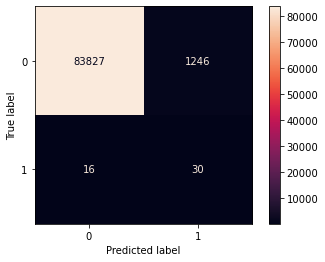

In [26]:
plot_confusion_matrix(cat_bayes, X_valid, y_valid, cmap='rocket', values_format='1')
plt.show()

In [27]:
def score_report(ytrue, ypred):
    print("Accuracy Score: ", accuracy_score(ytrue, ypred))
    print("Precision Score: ", precision_score(ytrue, ypred)) # a little difficult for this to tell us much given the small ratio of fatalities to accidents
    print("Recall Score: ", recall_score(ytrue, ypred)) # recall score is helpful, we can see that we are modeling almost 63% of accidents where there is a fatality     
    print("F1 Score: ", f1_score(ytrue, ypred))
    pass

In [28]:
score_report(y_valid, y_valid_pred)

Accuracy Score:  0.9851736979992716
Precision Score:  0.023510971786833857
Recall Score:  0.6521739130434783
F1 Score:  0.04538577912254161


In [29]:
print('''
      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent: ''',(df['INJURIES_FATAL'].sum()/df['INJURIES_FATAL'].count()*100))
print('''
      This is the total number of accidents with a fatality: ''',df['INJURIES_FATAL'].sum())
print('''
      This is the total number of accidents: ''', df['INJURIES_FATAL'].count())


      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent:  0.0553348817701523

      This is the total number of accidents with a fatality:  314

      This is the total number of accidents:  567454


In [30]:
# based on the above we can see that this model is missing the mark on attempting
# to predict where someone is likely to lose their life, missing on 16/43 actual
# fatalities. it additionally misclassifies 1166 accidents where there was no fatality
# but has indicated a false positive. The false positives are a problem in this model. 

In [31]:
selector = SelectKBest(score_func=chi2, k=15)

In [32]:
sel = selector.fit(X,y)

In [33]:
dfscores = sel.scores_
dfcols = X.columns

featscore = {}
for num in list(range(len(dfcols))):
    featscore[dfcols[num]] = round(dfscores[num], 2)
    
top_15 = {}
for item in sorted(featscore.items(), key=lambda x: x[1], reverse=True)[:15]:
    top_15[item[0]] = item[1]

In [34]:
top_15 # most impactful features indicating a fatality is likely

{'EJECTION_TRAPPED/EXTRICATED': 1576.42,
 'PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER': 1545.09,
 'TRAFFICWAY_TYPE_Y-INTERSECTION': 787.9,
 'FIRST_CRASH_TYPE_PEDESTRIAN': 779.2,
 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH': 543.34,
 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION': 406.01,
 'EJECTION_TOTALLY EJECTED': 327.73,
 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER': 255.74,
 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT': 239.85,
 'SAFETY_EQUIPMENT_HELMET NOT USED': 230.62,
 'REPORT_TYPE_ON SCENE': 212.29,
 'CRASH_TYPE_NO INJURY / DRIVE AWAY': 196.84,
 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)': 154.81,
 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS': 137.68,
 'NUM_UNITS': 134.0}

In [35]:
def getList(dict):
    return dict.keys()

new_features = getList(top_15)

In [36]:
top15_features = list(new_features)

In [37]:
# iterate through a second model using the 12 most impactful features
top15_features

['EJECTION_TRAPPED/EXTRICATED',
 'PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'TRAFFICWAY_TYPE_Y-INTERSECTION',
 'FIRST_CRASH_TYPE_PEDESTRIAN',
 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH',
 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION',
 'EJECTION_TOTALLY EJECTED',
 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT',
 'SAFETY_EQUIPMENT_HELMET NOT USED',
 'REPORT_TYPE_ON SCENE',
 'CRASH_TYPE_NO INJURY / DRIVE AWAY',
 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)',
 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS',
 'NUM_UNITS']

In [38]:
feature_list = ['EJECTION_TRAPPED/EXTRICATED',
 'PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'FIRST_CRASH_TYPE_PEDESTRIAN',
 'TRAFFICWAY_TYPE_Y-INTERSECTION',
 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH',
 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION',
 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'EJECTION_TOTALLY EJECTED',
 'REPORT_TYPE_ON SCENE',
 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT',
 'CRASH_TYPE_NO INJURY / DRIVE AWAY',
 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS',
 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)',
 'SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS',
 'NUM_UNITS']

X2 = df_train[feature_list]
y2 = df_train_y

In [39]:
cat_bayes.fit(X2,y2)

CategoricalNB()

In [40]:
df_valid_X = df_valid[feature_list]
df_valid_y = df_valid['INJURIES_FATAL']

X_valid2 = df_valid_X
y_valid2 = df_valid_y

In [41]:
X2.shape, y2.shape, X_valid2.shape, y_valid2.shape

((482335, 15), (482335,), (85119, 15), (85119,))

In [42]:
train_score2 = cat_bayes.score(X2, y2)
print(train_score2)

0.9912550405838266


In [43]:
test_score2 = cat_bayes.score(X_valid2, y_valid2)
print(test_score2)

0.9910125823846615


In [44]:
if(train_score2 > test_score2):
    print('Model is overfit')
else:
    print('Model is not overfit')

Model is overfit


In [45]:
y_valid_pred2 = cat_bayes.predict(X_valid2)

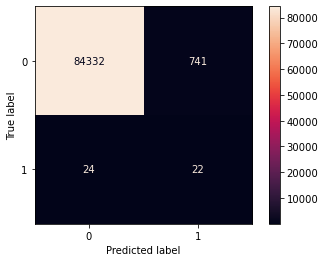

In [46]:
plot_confusion_matrix(cat_bayes, X_valid2, y_valid2, cmap='rocket', values_format='1')
plt.show()

### Model Insights - an improvement from our first model in terms of reducing false positives, but we also lost true positives and classified them as false negatives.

In [47]:
## optimize the model using a for loop and model type and a gridsearchCV
# BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB

In [48]:
ran_for = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
gau_NB = GaussianNB()

models = [ran_for, ada_clf, gb_clf, gau_NB, cat_bayes]

In [49]:
def model_opt(models, x, y, xtest, ytest):
    for model in models:
        fit = model.fit(x, y)
        ypred = model.predict(xtest)
        print(model," ", fit.score(x, y))
        plot_confusion_matrix(model, xtest, ytest, cmap='rocket', values_format='1')
        plt.show()
        score_report(ytest, ypred)
    pass

RandomForestClassifier()   1.0


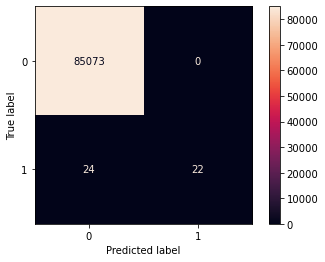

Accuracy Score:  0.9997180418003031
Precision Score:  1.0
Recall Score:  0.4782608695652174
F1 Score:  0.6470588235294118
AdaBoostClassifier()   0.999423637098697


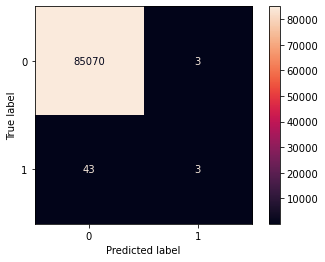

Accuracy Score:  0.9994595801172477
Precision Score:  0.5
Recall Score:  0.06521739130434782
F1 Score:  0.11538461538461539
GradientBoostingClassifier()   0.9994899810297823


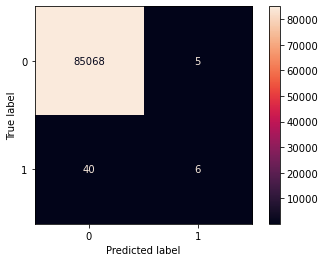

Accuracy Score:  0.9994713283755683
Precision Score:  0.5454545454545454
Recall Score:  0.13043478260869565
F1 Score:  0.21052631578947367
GaussianNB()   0.8329314687924368


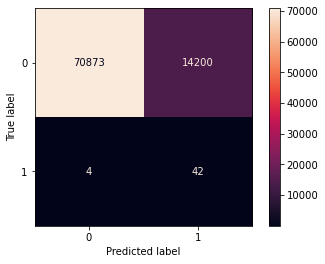

Accuracy Score:  0.8331277388127211
Precision Score:  0.0029490240134812527
Recall Score:  0.9130434782608695
F1 Score:  0.005879059350503919
CategoricalNB()   0.9865902329293955


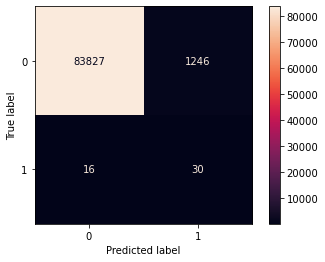

Accuracy Score:  0.9851736979992716
Precision Score:  0.023510971786833857
Recall Score:  0.6521739130434783
F1 Score:  0.04538577912254161


In [50]:
model_opt(models, X, y, X_valid, y_valid) # this is the full model dataset

### Out of the above models, Random Forest and Categorical Bayesian perform the best. Let's see if after applying feature selection if they continue to perform better than the other models. 

RandomForestClassifier()   0.9995044937647071


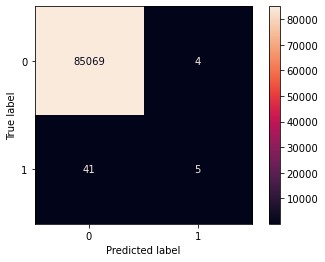

Accuracy Score:  0.9994713283755683
Precision Score:  0.5555555555555556
Recall Score:  0.10869565217391304
F1 Score:  0.1818181818181818
AdaBoostClassifier()   0.999434003337929


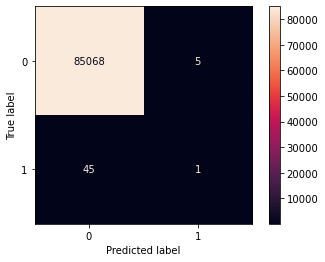

Accuracy Score:  0.9994125870839649
Precision Score:  0.16666666666666666
Recall Score:  0.021739130434782608
F1 Score:  0.03846153846153846
GradientBoostingClassifier()   0.9994651020556252


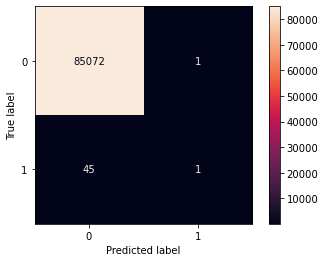

Accuracy Score:  0.9994595801172477
Precision Score:  0.5
Recall Score:  0.021739130434782608
F1 Score:  0.041666666666666664
GaussianNB()   0.7726103227010273


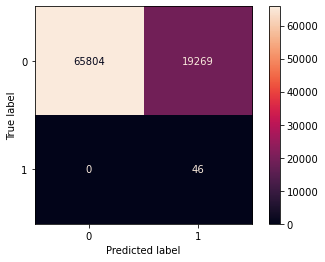

Accuracy Score:  0.7736228104183555
Precision Score:  0.002381568728967124
Recall Score:  1.0
F1 Score:  0.004751820670419915
CategoricalNB()   0.9912550405838266


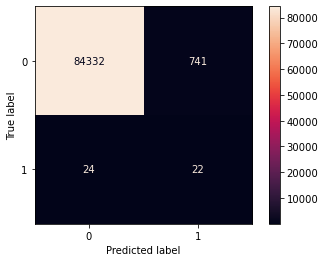

Accuracy Score:  0.9910125823846615
Precision Score:  0.028833551769331587
Recall Score:  0.4782608695652174
F1 Score:  0.05438813349814586


In [51]:
model_opt(models, X2, y2, X_valid2, y_valid2) # this is the reduced feature set

### Random Forest performed significantly worse with a reduced set of features, while Categorical Bayes went sideways, reducing overall false positives from ~ 1200 to ~ 700 but also losing some true positives to false negatives. 


### These are the top features that indicate any amount of deaths was likely during an accident in Chicago area crashes.

#### *EJECTION_TRAPPED/EXTRICATED (trapped within the vehicle requiring removal post-incident)
#### *PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER (intoxication)
#### *TRAFFICWAY_TYPE_Y-INTERSECTION (atypical traffic conditions)
#### *FIRST_CRASH_TYPE_PEDESTRIAN (a pedestrian is involved)
#### *CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH 
#### *AIRBAG_DEPLOYED_DEPLOYED, COMBINATION (higher speeds indicated)
#### *EJECTION_TOTALLY EJECTED (completed thrown from vehicle)
#### *SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER (intoxication)

In [55]:
# GridsearchCV and improving the full set Random Forest classifier
# GridsearchCV and improving the partial set CategoricalNB classifier

In [56]:
# create single item lists for input to model_opt
model1 = [cat_bayes]
model2 = [ran_for]

In [59]:
clf = DecisionTreeClassifier(max_depth=5)

In [67]:
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5)

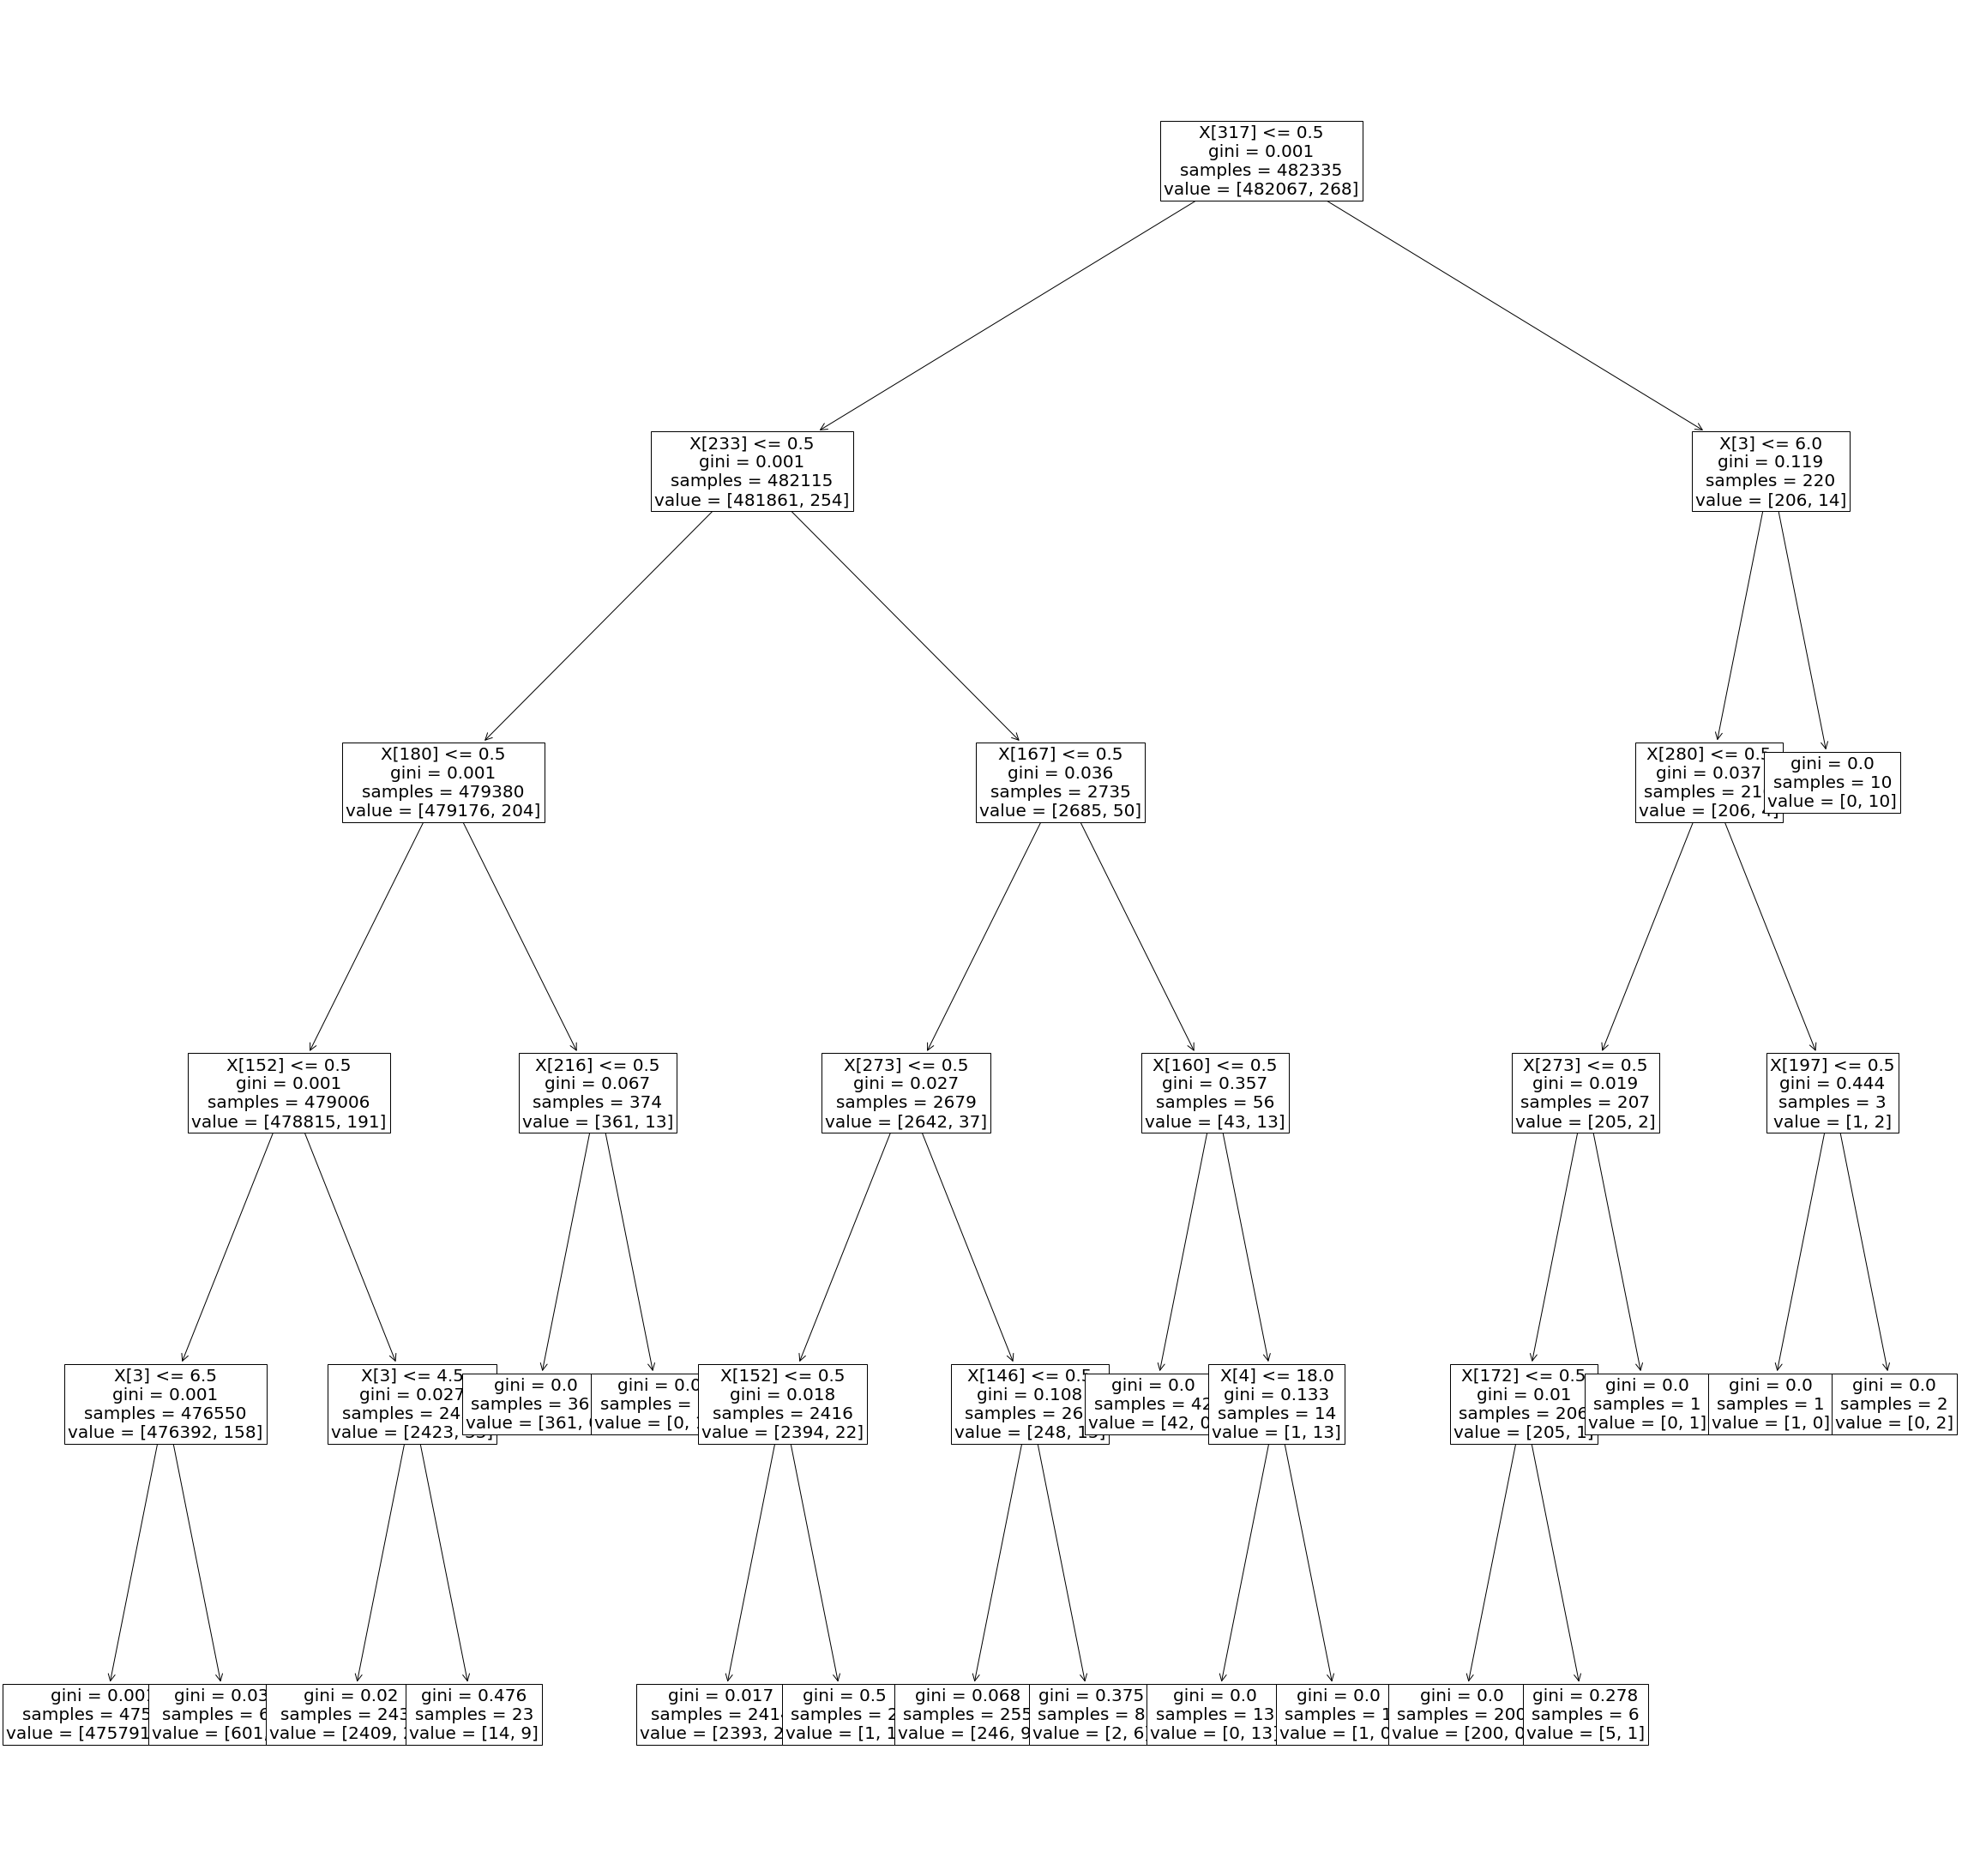

In [84]:
plt.figure(figsize=(40,40))
plot_tree(clf, fontsize=20)
plt.show()

In [ ]:
def model_scoring(models, )
for model in models:
    train_score = model.score(x_train_resampled, y_train_resampled)
    test_score = model.score(x_test, y_test)
    avg_score = (train_score + test_score)/2
    print(model ,train_score, test_score, avg_score)

In [ ]:
def evaluate_test_data(logreg, df_test, feature_for_modeling, target='y'):
    df_test = transform_dataframe(df_test)
    X = df_test[feature_for_modeling]
    y = df_test[target]
    score = logreg.score(X, y)
    print(f"Score of model = {score}")
    y_pred = logreg.predict(X)
    plot_confusion(y, y_pred)
    pass

evaluate_test_data(cat_bayes,df_test=df_valid, feature_for_modeling=feature_list)

In [ ]:
def cost_benefit_analysis(model, X_test, y_test):
    y_preds = model.predict(X_test)
    label_dict = {"TP":0, "FP": 0, "TN": 0, "FN": 0}
    for yt, yp in zip(y_test, y_preds):
        if yt==yp:
            if yt==1:
                label_dict["TP"] += 1
            else:
                label_dict["TN"] += 1
        else:
            if yp==1:
                label_dict["FP"] += 1
            else:
                label_dict["FN"] += 1
    cb_dict = {"TP": 50, "FP": -10, "TN": 0, "FN": -60}
    total = 0
    for key in label_dict.keys():
        total += cb_dict[key]*label_dict[key]
    return total / sum(label_dict.values())